<img src="img/Marca-ITBA-Color-ALTA.png" width="250">

# Master en Management & Analytics

## Programación para el Análisis de Datos

## Clase 3 parte 2 - Pandas - Agrupaciones y agregaciones

#### Referencias y bibliografía de consulta:

- Python for Data Analysis by Wes McKinney (O’Reilly) 2018 - capítulo 10

- https://pandas.pydata.org/

### Introducción

En la sección anterior se realizó una introducción a la transformación de datos utilizando funciones como `map`, `apply`, y `applymap`. Estas funciones son una de las piedras fundamentales en el análisis de datos.

Ahora se explorarán funciones que se utilizan para agrupar datos y realizar agregaciones con diferentes funciones y operaciones matemáticas.
La agrupación de datos se utiliza para ordenar y clasificar datos según un valor o categoría.

Después de cargar, fusionar y preparar un conjunto de datos, puede que sea necesario calcular estadísticas de grupo o tablas pivot para reportes y/o visualización.

El módulo `Pandas` provee métodos que nos permiten realizar estas tareas de forma natural.


- Dividir un objeto `Pandas` en partes usando una o más claves.

- Calcular estadísticos sobre grupos, como la media, el desvío estandar, o cualquier función definida por el usuario.

- Aplicar transformaciones por grupos.

- Construir tablas pivot.

In [344]:
import numpy as np
import pandas as pd
import dateutil
%matplotlib inline

Para empezar, importamos el dataset que utilizaremos a modo de ejemplo.
En la clase de hoy vamos a usar un dataset sobre datos de una compañía telefónica. Este dataset contiene la siguiente información
- **date**: Fecha y hora del evento. Formato 'DD/MM/YY HH:mm'
- **duration**: Duración en segundos de cada llamada, la cantidad de datos (en MB) enviados y la cantidad de mensajes de texto enviados.
- **item**: Descripción del evento. Puede ser uno de los 3 grupos: Llamada (call), SMS (sms) o GPRS (data)
- **month**: Mes de facturación al que corresponde el evento. Formato 'YYYY-MM'
- **network**: Red movil utilizada por el evento.
- **network_type**: Tipo de servicio utilizado. Llamada local a celular (mobile), llamada a teléfono fijo (landline), internacional (world), buzón de voz (voicemail), envio de datos (data) u otros (special).



Investiguemos el dataset!

In [345]:
dataset = pd.read_csv('data/phone_data.csv', index_col=0)

dataset.head()

,date,duration,item,month,network,network_type
index,,,,,,
0,15/10/14 06:58,34.429,data,2014-11,data,data
1,15/10/14 06:58,13.000,call,2014-11,Vodafone,mobile
2,15/10/14 14:46,23.000,call,2014-11,Meteor,mobile
3,15/10/14 14:48,4.000,call,2014-11,Tesco,mobile
4,15/10/14 17:27,4.000,call,2014-11,Tesco,mobile


In [346]:
dataset.sample(10)

,date,duration,item,month,network,network_type
index,,,,,,
344,03/12/14 15:01,844.000,call,2014-12,landline,landline
122,03/11/14 10:30,135.000,call,2014-11,Three,mobile
179,07/11/14 21:31,1.000,sms,2014-11,Vodafone,mobile
186,09/11/14 01:49,1.000,sms,2014-11,Three,mobile
611,17/01/15 18:50,78.000,call,2015-02,Three,mobile
301,25/11/14 19:21,29.000,call,2014-12,voicemail,voicemail
397,17/12/14 06:58,34.429,data,2015-01,data,data
672,31/01/15 13:14,7.000,call,2015-02,Vodafone,mobile
669,30/01/15 19:56,45.000,call,2015-02,Tesco,mobile


In [347]:
dataset.shape

(830, 6)

In [348]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 830 entries, 0 to 829
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          830 non-null    object 
 1   duration      830 non-null    float64
 2   item          830 non-null    object 
 3   month         830 non-null    object 
 4   network       830 non-null    object 
 5   network_type  830 non-null    object 
dtypes: float64(1), object(5)
memory usage: 45.4+ KB


In [349]:
dataset['item'].unique()

array(['data', 'call', 'sms'], dtype=object)

Vemos que la *feature* `date` está casteada como object. Vamos a Transformarlo en datetime. 

In [350]:
dataset['date'] = dataset['date'].apply(pd.to_datetime, dayfirst=True)

Tomemos una muestra de 3 elementos para ver cómo podemos trabajar con los datetime de `Pandas`:

In [351]:
samples_date = dataset.sample(3)['date']
samples_date

index
722   2015-02-09 22:54:00
523   2015-01-05 10:56:00
303   2014-11-25 19:26:00
Name: date, dtype: datetime64[ns]

In [352]:
print(f"days:\n{samples_date.dt.day}\n")
print(f"months:\n{samples_date.dt.month}\n")
print(f"years:\n{samples_date.dt.year}\n")

days:
index
722     9
523     5
303    25
Name: date, dtype: int64

months:
index
722     2
523     1
303    11
Name: date, dtype: int64

years:
index
722    2015
523    2015
303    2014
Name: date, dtype: int64



### Exploración de los datos

* ¿Qué período de tiempo abarca el dataset?

* ¿En qué meses hubo más facturación?

In [353]:
start = dataset['date'].min()
end = dataset['date'].max()

print(f"Período: {start.date()} - {end.date()}")

Período: 2014-10-15 - 2015-03-14


In [354]:
print("Cantidad de observaciones por mes")

print(dataset['date'].dt.month.value_counts().sort_index())

print(dataset['duration'].sort_index())

Cantidad de observaciones por mes
1     169
2     118
3      39
10    111
11    227
12    166
Name: date, dtype: int64
index
0      34.429
1      13.000
2      23.000
3       4.000
4       4.000
        ...  
825     1.000
826     1.000
827    34.429
828     1.000
829     1.000
Name: duration, Length: 830, dtype: float64


- Cuál es la duración máxima de las llamadas?

In [355]:
d_max = dataset[dataset['item'] =='call']['duration'].max()
print(f"La duración máxima de una llamada fue de {d_max} segundos")

La duración máxima de una llamada fue de 10528.0 segundos


- A qué llamada corresponde?

In [356]:
dataset[dataset['duration'] == d_max]

,date,duration,item,month,network,network_type
index,,,,,,
816,2015-03-04 12:29:00,10528.0,call,2015-03,landline,landline


In [357]:
dataset['duration'].mean()

117.80403614457833

Vamos a crear una variable categorica que divida los eventos de llamadas según la duración (mayor igual o menor a 117seg)

In [358]:
mask = (dataset['item'] == 'call') & (dataset['duration'] < 117)
dataset.loc[mask, 'key_bin'] = 'D0'
dataset.loc[~ mask, 'key_bin'] = 'D1'

In [359]:
dataset.sample(10, random_state=1)

,date,duration,item,month,network,network_type,key_bin
index,,,,,,,
786,2015-02-28 17:14:00,3.000,call,2015-03,landline,landline,D0
522,2015-01-05 10:52:00,1.000,sms,2015-01,Three,mobile,D1
811,2015-03-04 06:58:00,34.429,data,2015-03,data,data,D1
579,2015-01-13 19:09:00,1.000,sms,2015-01,Three,mobile,D1
573,2015-01-12 12:01:00,7.000,call,2015-01,Meteor,mobile,D0
8,2014-10-16 15:12:00,1050.000,call,2014-11,Three,mobile,D1
457,2014-12-24 13:56:00,3.000,call,2015-01,Three,mobile,D0
364,2014-12-07 13:03:00,99.000,call,2014-12,voicemail,voicemail,D0
610,2015-01-17 06:58:00,34.429,data,2015-02,data,data,D1


Para poder contestar preguntas mas complejas, se define el concepto de agrupación por clave, o **group by**.

Pandas implementa un método especial para este tipo de tareas.

## GroupBy

Podemos describir las operaciones sobre grupos con el términos del proceso **split-apply-combine**. 

En la primera etapa del proceso, el **split**, los datos en un objeto `Pandas` (una instancia de `Series` o de `DataFrame`) se dividen en grupos en base a una o más claves. Esta división se lleva a cabo por filas (axis = 0) o por columnas (axis = 1).

Luego, en la fase de **apply**, aplicamos una función a cada uno de los grupos dando como resultado un nuevo valor por grupo.

En el último paso, el **combine**, los resultados de la aplicación de la función en cada uno de los grupos se combinan en un objeto resultado.

<img src="img/split_apply_combine.png" width="450">

el `GroupBy` realiza todo este proceso en un solo paso. 

En el paso de *Apply* se puede necesitar realizar distintas operaciones, como pueden ser:

- Aggregaciones: Aplica una función de reduccion, generalmente estadistica (suma, cantidad, media), para cada uno de los subgrupos
- Transformaciones: Aplicar una transformación específica para cada uno de los subgrupos. (Completar nulos)
- Filtrado: Filtra en función del grupo. (Descartar algunos grupos, eliminar outliers)

Las operaciones de group by se realizan con el objeto **GroupBy**

### El objeto GroupBy



El objeto `GroupBy` es un abstracción muy flexible. Pandas permite utilizar el objeto tanto para `DataFrame` como para `Serie`.

Este objeto **NO** retorna un `DataFrame`, sino un objeto `DataFrameGroupBy`. 

In [360]:
grouped_item = dataset.groupby('item')
grouped_item1 = dataset.groupby(['item']).sum()

print(grouped_item1)
print("--------------------------------")
print(grouped_item.groups)
print(grouped_item.get_group("call"))

      duration
item          
call  92321.00
data   5164.35
sms     292.00
--------------------------------
{'call': [1, 2, 3, 4, 5, 7, 8, 9, 10, 19, 20, 21, 27, 28, 29, 30, 31, 32, 34, 35, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 55, 57, 59, 60, 64, 65, 78, 82, 83, 84, 85, 86, 88, 89, 90, 91, 93, 94, 96, 98, 99, 100, 104, 105, 106, 109, 110, 112, 113, 115, 116, 117, 118, 119, 122, 123, 124, 126, 127, 128, 129, 130, 136, 137, 139, 140, 141, 146, 147, 150, 152, 156, 162, 163, 164, 165, 166, 168, 169, 171, 172, 183, 184, 190, 191, 193, 194, 195, 196, ...], 'data': [0, 6, 13, 26, 39, 45, 54, 56, 58, 66, 80, 81, 87, 92, 95, 97, 101, 111, 114, 120, 131, 151, 159, 170, 182, 189, 192, 199, 208, 228, 231, 234, 235, 237, 238, 249, 254, 263, 275, 281, 288, 291, 305, 321, 324, 328, 330, 338, 341, 343, 346, 351, 355, 363, 372, 374, 376, 377, 378, 381, 386, 389, 396, 397, 400, 409, 420, 426, 427, 443, 453, 463, 465, 468, 473, 474, 476, 496, 504, 505, 509, 512, 516, 529, 537, 541, 555, 560, 568, 

Con el atributo `groups` podemos ver cómo repartió a los elementos del `index` en lo diferentes grupos. El atributo groups nos muestra un diccionario cuyas claves son los items y los valores son los índices para cada item.

In [361]:
grouped_item.groups

{'call': [1, 2, 3, 4, 5, 7, 8, 9, 10, 19, 20, 21, 27, 28, 29, 30, 31, 32, 34, 35, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 55, 57, 59, 60, 64, 65, 78, 82, 83, 84, 85, 86, 88, 89, 90, 91, 93, 94, 96, 98, 99, 100, 104, 105, 106, 109, 110, 112, 113, 115, 116, 117, 118, 119, 122, 123, 124, 126, 127, 128, 129, 130, 136, 137, 139, 140, 141, 146, 147, 150, 152, 156, 162, 163, 164, 165, 166, 168, 169, 171, 172, 183, 184, 190, 191, 193, 194, 195, 196, ...], 'data': [0, 6, 13, 26, 39, 45, 54, 56, 58, 66, 80, 81, 87, 92, 95, 97, 101, 111, 114, 120, 131, 151, 159, 170, 182, 189, 192, 199, 208, 228, 231, 234, 235, 237, 238, 249, 254, 263, 275, 281, 288, 291, 305, 321, 324, 328, 330, 338, 341, 343, 346, 351, 355, 363, 372, 374, 376, 377, 378, 381, 386, 389, 396, 397, 400, 409, 420, 426, 427, 443, 453, 463, 465, 468, 473, 474, 476, 496, 504, 505, 509, 512, 516, 529, 537, 541, 555, 560, 568, 571, 577, 586, 594, 598, 610, 613, 616, 621, 625, 634, ...], 'sms': [11, 12, 14, 15, 16, 17, 18, 22, 23, 24,

In [362]:
grouped_item.groups.keys()

dict_keys(['call', 'data', 'sms'])

In [363]:
grouped_item.groups['call']

Int64Index([  1,   2,   3,   4,   5,   7,   8,   9,  10,  19,
            ...
            801, 802, 803, 805, 806, 807, 808, 809, 810, 816],
           dtype='int64', name='index', length=388)

Se puede pensar en el `DataFrameGroupBy` como una vista especial de un `DataFrame` que construye los grupos pero que no realiza ningún cómputo hasta que la etapa de agregación es aplicada.

Para producir un resultado podemos aplicar una función de agregación a este `DataFrameGroupBy` que a realiza la operación (apply) y avanza en el paso de combine.

Veamos algunos ejemplos:

In [364]:
print(grouped_item[['duration']].mean())
print(type(grouped_item[['duration']].mean()))

        duration
item            
call  237.940722
data   34.429000
sms     1.000000
<class 'pandas.core.frame.DataFrame'>


In [365]:
grouped_item['duration'].mean()

item
call    237.940722
data     34.429000
sms       1.000000
Name: duration, dtype: float64

In [366]:
grouped_item[['duration']].std()

,duration
item,
call,628.551264
data,0.000000
sms,0.000000


También se pueden realizar operaciones mas complejas para contestar preguntas cómo.
- Cuál es el promedio de la duración de llamada para cada red utilizada?

In [367]:
dataset[dataset['item'] == 'call'].groupby('network')[['duration']].mean()
# df -> df filtrado por columna "item" igual al valor "call", agrupado por "network", tomando la columna "duration" y la media

,duration
network,
Meteor,133.333333
Tesco,194.760563
Three,284.875000
Vodafone,221.530303
landline,438.880952
voicemail,65.740741


El `GroupBy` también nos permite utilizar más de una clave:

In [404]:
a = list(dataset.groupby(['month', 'item']).groups.keys())
# en "a", agrupa y devuelve una lista con los keys
print(a)
print(type(a))
print(dataset.groupby(['month', 'item']).groups)
print(type(dataset.groupby(['month', 'item']).groups))
# Si no pongo "keys()" devuelve un formato de diccionario de pandas. Los keys son los valores de los indices del groupby
# y los "items()" serían listas de los valores dentro de ese agrupamiento
print(pd.to_datetime(a[0][0]), type(pd.to_datetime(a[0][0])))
# pd.to_datetime transforma en fecha
print(dataset.groupby(['month', 'item']).get_group(('2014-11', 'call')).iloc[[0,1]])

[('2014-11', 'call'), ('2014-11', 'data'), ('2014-11', 'sms'), ('2014-12', 'call'), ('2014-12', 'data'), ('2014-12', 'sms'), ('2015-01', 'call'), ('2015-01', 'data'), ('2015-01', 'sms'), ('2015-02', 'call'), ('2015-02', 'data'), ('2015-02', 'sms'), ('2015-03', 'call'), ('2015-03', 'data'), ('2015-03', 'sms')]
<class 'list'>
{('2014-11', 'call'): [1, 2, 3, 4, 5, 7, 8, 9, 10, 19, 20, 21, 27, 28, 29, 30, 31, 32, 34, 35, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 55, 57, 59, 60, 64, 65, 78, 82, 83, 84, 85, 86, 88, 89, 90, 91, 93, 94, 96, 98, 99, 100, 104, 105, 106, 109, 110, 112, 113, 115, 116, 117, 118, 119, 122, 123, 124, 126, 127, 128, 129, 130, 136, 137, 139, 140, 141, 146, 147, 150, 152, 156, 162, 163, 164, 165, 166, 168, 169, 171, 172, 183, 184, 190, 191, 193, 194, 195, 196, ...], ('2014-11', 'data'): [0, 6, 13, 26, 39, 45, 54, 56, 58, 66, 80, 81, 87, 92, 95, 97, 101, 111, 114, 120, 131, 151, 159, 170, 182, 189, 192, 199, 208], ('2014-11', 'sms'): [11, 12, 14, 15, 16, 17, 18, 22, 23

Se puede ver que se genera una clave para cada combinación única de ambas columnas.

La cantidad máxima de claves resulta ser $C_1*C_2$, siendo $C_i$ la cardinalidad de la columna $i$

In [369]:
dataset.groupby(['month', 'item'])[['date']].count()

date
month   item      
2014-11 call   107
        data    29
        sms     94
2014-12 call    79
        data    30
        sms     48
2015-01 call    88
        data    31
        sms     86
2015-02 call    67
        data    31
        sms     39
2015-03 call    47
        data    29
        sms     25

In [370]:
dataset.groupby(['month', 'item']).size()

month    item
2014-11  call    107
         data     29
         sms      94
2014-12  call     79
         data     30
         sms      48
2015-01  call     88
         data     31
         sms      86
2015-02  call     67
         data     31
         sms      39
2015-03  call     47
         data     29
         sms      25
dtype: int64

In [371]:
dataset.groupby(['month', 'item', 'network_type']).size()

# Agrupa por los items ['month', 'item', 'network_type'] y cuenta la cantidad de observaciones dentro de cada grupo.

month    item  network_type
2014-11  call  landline         5
               mobile          96
               voicemail        6
         data  data            29
         sms   mobile          93
               special          1
2014-12  call  landline         7
               mobile          64
               voicemail        8
         data  data            30
         sms   mobile          44
               world            4
2015-01  call  landline        11
               mobile          74
               voicemail        3
         data  data            31
         sms   mobile          86
2015-02  call  landline         8
               mobile          53
               voicemail        6
         data  data            31
         sms   mobile          37
               special          2
2015-03  call  landline        11
               mobile          32
               voicemail        4
         data  data            29
         sms   mobile          22
               world

El tipo de dato de salida depende de la cantidad de columnas y como se seleccionen. 
Esto es similar a la selección de columnas dentro de un dataframe.

In [372]:
print("Utilizando [], el tipo de dato es: {}".format(type(dataset.groupby(['month', 'item'])['date'].count())))
print("Utilizando [[]], el tipo de dato es: {}".format(type(dataset.groupby(['month', 'item'])[['date']].count())))


Utilizando [], el tipo de dato es: <class 'pandas.core.series.Series'>
Utilizando [[]], el tipo de dato es: <class 'pandas.core.frame.DataFrame'>


## Aggregation

El método `aggregate()` puede tomar un string, una función o una lista y computar todos los agregados en un solo paso.

In [373]:
def x_sobre_x(x):
    x = x**2
    return x

dataset.groupby(['item','network_type'])[['duration']].aggregate([np.min, np.mean, np.median,\
                                                      np.max, np.ma.count, np.std, sum]).apply(lambda x: x/10000000000)

# np.ma = masked array

duration                                            \
                           amin          mean        median          amax   
item network_type                                                           
call landline      3.000000e-10  4.388810e-08  7.500000e-09  1.052800e-06   
     mobile        1.000000e-10  2.260596e-08  6.200000e-09  2.328000e-07   
     voicemail     1.000000e-10  6.574074e-09  6.300000e-09  1.740000e-08   
data data          3.442900e-09  3.442900e-09  3.442900e-09  3.442900e-09   
sms  mobile        1.000000e-10  1.000000e-10  1.000000e-10  1.000000e-10   
     special       1.000000e-10  1.000000e-10  1.000000e-10  1.000000e-10   
     world         1.000000e-10  1.000000e-10  1.000000e-10  1.000000e-10   

                                                             
                          count           std           sum  
item network_type                                            
call landline      4.200000e-09  1.631416e-07  1.843300e-06  
     mobile        3.190000e-08  3.598566e-08  7.211300e-06  
     voicemail     2.700000e-09  4.429498e-09  1.775000e-07  
data data          1.500000e-08  0.000000e+00  5.164350e-07  
sms  mobile        2.820000e-08  0.000000e+00  2.820000e-08  
     special       3.000000e-10  0.000000e+00  3.000000e-10  
     world         7.000000e-10  0.000000e+00  7.000000e-10

In [374]:
type(dataset.groupby('item')['duration'].aggregate([np.min, np.mean, np.median,\
                                                      np.max, np.ma.count, np.std]))

pandas.core.frame.DataFrame

Como el resultado es un DataFrame, podemos por ejemplo cambiar el nombre de las columnas:

In [375]:
df_gb = dataset.groupby('item')['duration'].aggregate([np.min, np.mean, np.median,\
                                                      np.max, np.ma.count, np.std])

# Aggregate (a diferencia de agg) es una lista de operaciones (no un diccionario).
# Los nombres de las columnas los genera el mismo metodo
# np.ma => no tiene en cuenta valores nan
# tener en cuenta que tienen que ser válidas para agrupar.

df_gb = df_gb.rename(columns={'amin': 'valor mínimo', 'mean': 'media',
                'median': 'mediana','amax':'valor máximo','std': 'desvío estándar',\
                                 'count':'#registros'})

In [376]:
df_gb

,valor mínimo,media,mediana,valor máximo,#registros,desvío estándar
item,,,,,,
call,1.000,237.940722,68.500,10528.000,388,628.551264
data,34.429,34.429000,34.429,34.429,150,0.000000
sms,1.000,1.000000,1.000,1.000,292,0.000000


De forma más simple, se puede utilizar el método `agg`, que toma un diccionario para indicar los nombres de las columnas y las funciones de agregación a utilizar.

In [377]:
dataset.groupby(
   ['month', 'item']
).agg(
    {
         'duration': sum,    # Suma duración por grupo
         'network_type': 'count',  # cuenta el network_type
         'date': 'first' # primera fecha
    }
)

# Agrupa por "month" e "item" creando un dataframe que devuelve 3 columnas, que se identifican en el diccionario dentro del metodo "agg"
# "duration" va a ser la suma de los valores agrupados.
# "network_type": es la cantidad de observaciones con valor de esa misma columna
# "date": devuelve la primer ocurrencia del valor "date" del dataframe "dataset"

duration  network_type                date
month   item                                             
2014-11 call  25547.000           107 2014-10-15 06:58:00
        data    998.441            29 2014-10-15 06:58:00
        sms      94.000            94 2014-10-16 22:18:00
2014-12 call  13561.000            79 2014-11-14 17:24:00
        data   1032.870            30 2014-11-13 06:58:00
        sms      48.000            48 2014-11-14 17:28:00
2015-01 call  17070.000            88 2014-12-15 20:03:00
        data   1067.299            31 2014-12-13 06:58:00
        sms      86.000            86 2014-12-15 19:56:00
2015-02 call  14416.000            67 2015-01-15 10:36:00
        data   1067.299            31 2015-01-13 06:58:00
        sms      39.000            39 2015-01-15 12:23:00
2015-03 call  21727.000            47 2015-02-12 20:15:00
        data    998.441            29 2015-02-13 06:58:00
        sms      25.000            25 2015-02-19 18:46:00

`agg` tambien nos permite aplicar distintas funciones de agregación para la misma columna

In [378]:
a = dataset.groupby(
    ['month', 'item']
).agg(
    {
        'duration': [np.min, np.max, np.sum],
        'network_type': "count",
        'date': ['first', 'last', 'nunique']
    }
)
display(a)
print(a.columns)
print(a.index)

duration                       network_type                date  \
                 amin       amax        sum        count               first   
month   item                                                                   
2014-11 call    1.000   1940.000  25547.000          107 2014-10-15 06:58:00   
        data   34.429     34.429    998.441           29 2014-10-15 06:58:00   
        sms     1.000      1.000     94.000           94 2014-10-16 22:18:00   
2014-12 call    2.000   2120.000  13561.000           79 2014-11-14 17:24:00   
        data   34.429     34.429   1032.870           30 2014-11-13 06:58:00   
        sms     1.000      1.000     48.000           48 2014-11-14 17:28:00   
2015-01 call    2.000   1859.000  17070.000           88 2014-12-15 20:03:00   
        data   34.429     34.429   1067.299           31 2014-12-13 06:58:00   
        sms     1.000      1.000     86.000           86 2014-12-15 19:56:00   
2015-02 call    1.000   1863.000  14416.000           67 2015-01-15 10:36:00   
        data   34.429     34.429   1067.299           31 2015-01-13 06:58:00   
        sms     1.000      1.000     39.000           39 2015-01-15 12:23:00   
2015-03 call    2.000  10528.000  21727.000           47 2015-02-12 20:15:00   
        data   34.429     34.429    998.441           29 2015-02-13 06:58:00   
        sms     1.000      1.000     25.000           25 2015-02-19 18:46:00   

                                          
                            last nunique  
month   item                              
2014-11 call 2014-11-12 19:01:00     104  
        data 2014-11-12 06:58:00      29  
        sms  2014-11-13 22:31:00      79  
2014-12 call 2014-12-14 19:54:00      76  
        data 2014-12-12 06:58:00      30  
        sms  2014-12-07 23:22:00      41  
2015-01 call 2015-01-14 20:47:00      84  
        data 2015-01-12 06:58:00      31  
        sms  2015-01-14 23:36:00      58  
2015-02 call 2015-02-09 17:54:00      67  
        data 2015-02-12 06:58:00      31  
        sms  2015-02-10 21:40:00      27  
2015-03 call 2015-03-04 12:29:00      47  
        data 2015-03-13 06:58:00      29  
        sms  2015-03-14 00:16:00      17

MultiIndex([(    'duration',    'amin'),
            (    'duration',    'amax'),
            (    'duration',     'sum'),
            ('network_type',   'count'),
            (        'date',   'first'),
            (        'date',    'last'),
            (        'date', 'nunique')],
           )
MultiIndex([('2014-11', 'call'),
            ('2014-11', 'data'),
            ('2014-11',  'sms'),
            ('2014-12', 'call'),
            ('2014-12', 'data'),
            ('2014-12',  'sms'),
            ('2015-01', 'call'),
            ('2015-01', 'data'),
            ('2015-01',  'sms'),
            ('2015-02', 'call'),
            ('2015-02', 'data'),
            ('2015-02',  'sms'),
            ('2015-03', 'call'),
            ('2015-03', 'data'),
            ('2015-03',  'sms')],
           names=['month', 'item'])


### Filtering

- Una operación de `filtering` permite descartar datos basado en propiedades del grupo.
- Por ejemplo, podríamos querer mantener todos los grupos en los que la desviación estándar sea mayor que algún valor de corte:

In [379]:
dataset.groupby('month').filter(lambda x: x['duration'].std() > 250)

,date,duration,item,month,network,network_type,key_bin
index,,,,,,,
0,2014-10-15 06:58:00,34.429,data,2014-11,data,data,D1
1,2014-10-15 06:58:00,13.000,call,2014-11,Vodafone,mobile,D0
2,2014-10-15 14:46:00,23.000,call,2014-11,Meteor,mobile,D0
3,2014-10-15 14:48:00,4.000,call,2014-11,Tesco,mobile,D0
4,2014-10-15 17:27:00,4.000,call,2014-11,Tesco,mobile,D0
...,...,...,...,...,...,...,...
825,2015-03-13 00:38:00,1.000,sms,2015-03,world,world,D1
826,2015-03-13 00:39:00,1.000,sms,2015-03,Vodafone,mobile,D1
827,2015-03-13 06:58:00,34.429,data,2015-03,data,data,D1


In [380]:
print(dataset.groupby('month').filter(lambda x: x['duration'].std() > 250)['month'].unique())
display(dataset.groupby('month').apply(lambda x: x['duration'].std())) # Esto lo agregué yo, para chequear que dé bien el filtro.

# Agrupa el dataset por la columna "month" y para filtrar crea una máscara, que es el valor del desvío de la duration
# sujeto a que sea mayor a 250.

['2014-11' '2015-02' '2015-03']


month
2014-11     287.548051
2014-12     243.151296
2015-01     216.853383
2015-02     250.778963
2015-03    1076.018287
dtype: float64

In [400]:
dfx = pd.DataFrame({"data":[1,23,3,48,5,6,744,8,9],
                   "cuenta": ["a","a","b","b","c","b","a","b","b"]})
#print(dfx.dtypes)
#print(dfx.columns)
#display(dfx)
# dfx["std"] = dfx.groupby("cuenta").apply(lambda x: x+x["data"].mean())
display(dfx.groupby("cuenta").filter(lambda x: x["data"].mean() > 200)["data"].unique())

array([  1,  23, 744], dtype=int64)

Podemos aplicar el método `describe()` al `Groupby` y ver que, efectivamente, solamente los meses `2014-11`, `2015-02` y `2015-03` tienen un desvío estándar mayor a 250 en la variable 'duration'. 

In [382]:
dataset.groupby('month').describe()

duration                                                            
           count        mean          std  min  25%     50%     75%      max
month                                                                       
2014-11    230.0  115.823657   287.548051  1.0  1.0   4.000   36.75   1940.0
2014-12    157.0   93.260318   243.151296  1.0  1.0  28.000   55.00   2120.0
2015-01    205.0   88.894141   216.853383  1.0  1.0   6.000   41.00   1859.0
2015-02    137.0  113.301453   250.778963  1.0  1.0  34.429   82.00   1863.0
2015-03    101.0  225.251891  1076.018287  1.0  2.0  34.429  106.00  10528.0

### Transformation

Mientras que aggregation devuelve una versión reducida de los datos, transformation retorna alguna versión transformada de los datos para, luego, hacer el combine.

El output de una transformation es del mismo `shape` que el input.



In [383]:
dataset.head()

,date,duration,item,month,network,network_type,key_bin
index,,,,,,,
0,2014-10-15 06:58:00,34.429,data,2014-11,data,data,D1
1,2014-10-15 06:58:00,13.000,call,2014-11,Vodafone,mobile,D0
2,2014-10-15 14:46:00,23.000,call,2014-11,Meteor,mobile,D0
3,2014-10-15 14:48:00,4.000,call,2014-11,Tesco,mobile,D0
4,2014-10-15 17:27:00,4.000,call,2014-11,Tesco,mobile,D0


In [384]:
dataset['media_mensual'] = dataset.groupby('month')['duration'].transform('mean')
dataset[['month', 'media_mensual']]

,month,media_mensual
index,,
0,2014-11,115.823657
1,2014-11,115.823657
2,2014-11,115.823657
3,2014-11,115.823657
4,2014-11,115.823657
...,...,...
825,2015-03,225.251891
826,2015-03,225.251891
827,2015-03,225.251891


The `apply` and `transform` methods in Pandas are used in conjunction with the `groupby` method call.

The main difference between these two methods is that `apply` accepts a DataFrame as an argument and returns a scalar or a sequence of the data frame, while `transform` returns an object that is the same size as the group or broadcastable to the size of the chunk¹.

For example, if we have a DataFrame with two columns "A" and "B", we can use the `groupby` method to group the data by column "A" and then apply a function to each group using either `apply` or `transform`. Here's an example:

```
import pandas as pd

df = pd.DataFrame({
    'A': ['foo', 'bar', 'foo', 'bar', 'foo', 'bar', 'foo', 'foo'],
    'B': ['one', 'one', 'two', 'three', 'two', 'two', 'one', 'three'],
    'C': [1, 2, 3, 4, 5, 6, 7, 8],
    'D': [9, 10, 11, 12, 13, 14, 15, 16]
})

# Group by column "A" and apply sum function to column "C"
df.groupby('A')['C'].apply(sum)

# Group by column "A" and transform sum function to column "C"
df.groupby('A')['C'].transform(sum)
```

In this example, both methods will return a new DataFrame with the sum of column "C" for each group in column "A". However, the difference is that `apply` will return a new DataFrame with only two rows (one for each group), while `transform` will return a new DataFrame with eight rows (the same size as the original DataFrame).

I hope this helps! Let me know if you have any other questions.

Origen: Conversación con Bing, 14/4/2023(1) python - Pandas groupby apply vs transform with specific functions .... https://stackoverflow.com/questions/51079543/pandas-groupby-apply-vs-transform-with-specific-functions Con acceso 14/4/2023.
(2) Pandas Apply Transform With Groupby | Delft Stack. https://www.delftstack.com/howto/python-pandas/pandas-apply-transform-with-groupby/ Con acceso 14/4/2023.
(3) Group by: split-apply-combine — pandas 2.0.0 documentation. https://pandas.pydata.org/docs/user_guide/groupby.html Con acceso 14/4/2023.

### El método `apply()`

El método `apply()` permite aplicar alguna función dada a los resultados del grupo.

La función debería tomar como input ``DataFrame`` y devolver un objeto `Pandas` o un escalar. 

La operación combine se adaptará al tipo de salida.

En el siguiente ejemplo, se obtiene la normalización estandar de la duración según el mes.

In [385]:
dataset['norm_duration'] = dataset.groupby('month', group_keys=False)['duration'].apply(lambda x: (x-x.mean())/x.std())
dataset

# dataset -> el df que usa
# groupby('month') -> crea un objeto que queda guardado en la memoria. Por sí solo no se puede utilizar.
# ['duration'] -> es la columna donde busca los valores para aplicar una fórmula. Si no especifico, busca las columnas númericas
# y aplica sobre todas ellas. Pasa algo similar con ciertos metodos como describe.
# apply -> El método apply en Pandas se utiliza para aplicar una función a cada fila o columna de un DataFrame. 
# La función se aplica a cada elemento de la fila o columna y devuelve un nuevo DataFrame con los resultados.
# lambda x -> la función lambda es una función anónima que se utiliza para definir funciones simples en una sola línea.
# En este caso, calcula la diferencia entre el valor de la fila, menos la media de esa columna (o fila) sobre el desvío.
# dataset['norm_duration'] -> Crea una columna donde se asigna cada valor que se calculó.

,date,duration,item,month,network,network_type,key_bin,media_mensual,norm_duration
index,,,,,,,,,
0,2014-10-15 06:58:00,34.429,data,2014-11,data,data,D1,115.823657,-0.283065
1,2014-10-15 06:58:00,13.000,call,2014-11,Vodafone,mobile,D0,115.823657,-0.357588
2,2014-10-15 14:46:00,23.000,call,2014-11,Meteor,mobile,D0,115.823657,-0.322811
3,2014-10-15 14:48:00,4.000,call,2014-11,Tesco,mobile,D0,115.823657,-0.388887
4,2014-10-15 17:27:00,4.000,call,2014-11,Tesco,mobile,D0,115.823657,-0.388887
...,...,...,...,...,...,...,...,...,...
825,2015-03-13 00:38:00,1.000,sms,2015-03,world,world,D1,225.251891,-0.208409
826,2015-03-13 00:39:00,1.000,sms,2015-03,Vodafone,mobile,D1,225.251891,-0.208409
827,2015-03-13 06:58:00,34.429,data,2015-03,data,data,D1,225.251891,-0.177342


In [386]:
dataset.head()

,date,duration,item,month,network,network_type,key_bin,media_mensual,norm_duration
index,,,,,,,,,
0,2014-10-15 06:58:00,34.429,data,2014-11,data,data,D1,115.823657,-0.283065
1,2014-10-15 06:58:00,13.000,call,2014-11,Vodafone,mobile,D0,115.823657,-0.357588
2,2014-10-15 14:46:00,23.000,call,2014-11,Meteor,mobile,D0,115.823657,-0.322811
3,2014-10-15 14:48:00,4.000,call,2014-11,Tesco,mobile,D0,115.823657,-0.388887
4,2014-10-15 17:27:00,4.000,call,2014-11,Tesco,mobile,D0,115.823657,-0.388887


A continuación se muestran las distribuciones previo a la transformación y posterior a la transformación.


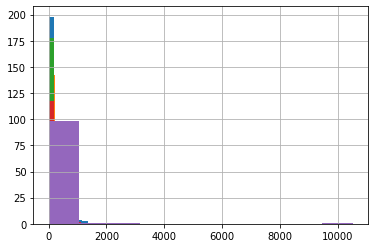

In [387]:
dataset.groupby('month')['duration'].hist();

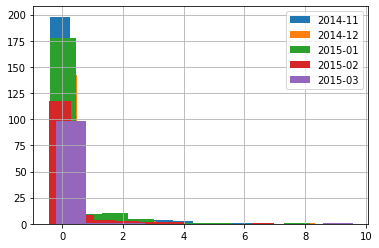

In [388]:
dataset.groupby('month')['norm_duration'].hist(legend=True);

## Pivot_table

In [389]:
dataset.head()

,date,duration,item,month,network,network_type,key_bin,media_mensual,norm_duration
index,,,,,,,,,
0,2014-10-15 06:58:00,34.429,data,2014-11,data,data,D1,115.823657,-0.283065
1,2014-10-15 06:58:00,13.000,call,2014-11,Vodafone,mobile,D0,115.823657,-0.357588
2,2014-10-15 14:46:00,23.000,call,2014-11,Meteor,mobile,D0,115.823657,-0.322811
3,2014-10-15 14:48:00,4.000,call,2014-11,Tesco,mobile,D0,115.823657,-0.388887
4,2014-10-15 17:27:00,4.000,call,2014-11,Tesco,mobile,D0,115.823657,-0.388887


In [390]:
dataset.pivot_table(values='duration', index='month', columns='key_bin', aggfunc='count')
# values -> valores sobres los que se hacen los calculos
# index -> valores sobre los que agrupa los indices
# columns -> valores sobre los que crea las columnas
# aggfunc = "count", cuenta las observaciones de D0 y D1 agrupadas por "month".

key_bin,D0,D1
month,,
2014-11,66,164
2014-12,54,103
2015-01,55,150
2015-02,40,97
2015-03,24,77


Los argumentos del método `pivot_table` son: 
-  el campo sobre el que vamos a calcular la función de agregación, en este caso $mean$.
-  index define la columna del `DataFrame` original cuyos valores sirven de índice de la tabla dinámica.
-  `columns` define la columna del `DataFrame` original cuyos valores sirven de columnas de la tabla dinámica


Podemos agregar los totales con el parámetro `margins=True`

In [391]:
dataset.pivot_table(values='duration', index=['month', 'network'], columns=['key_bin'],\
                    margins=True, margins_name= 'totales')# , aggfunc="sum")
# Pivot Table: crea una tabla nueva, desde un dataframe, donde:
# >>>>>>>>>> Sirve para crear una tabla transpuesta que compara valores de manera más simple y permite agrupar y hacer
# transformaciones agregadas a los datos.
# >>>>>>>>>> Las columnas son los valores de las columnas del dataframe previo.
# >>>>>>>>>> Los indices son también valores de las columnas del dataframe previo.
# >>>>>>>>>> Por default, en este caso calculaba la media de "duration" de los valores de la columna "key_bin" agrupados "month" y "network".
# >>>>>>>>>> margins=True, margins_name= 'totales'calcula la media del total (D0+D1) / total de observaciones.
# >>>>>>>>>> con aggfunc="sum" calculo la suma.
# Se puede probar sacabndo el aggfunc. Da la media.

key_bin                   D0           D1      totales
month   network                                       
2014-11 Meteor     19.875000    91.466667    66.565217
        Tesco      11.076923   390.400000   176.000000
        Three      31.523810   274.906977   195.046875
        Vodafone   21.250000    63.984127    55.329114
        data             NaN    34.429000    34.429000
        landline    5.000000   965.333333   581.200000
        special          NaN     1.000000     1.000000
        voicemail  50.166667          NaN    50.166667
2014-12 Meteor     51.142857    97.882353    84.250000
        Tesco      37.666667   227.714286   140.000000
        Three      18.904762   269.636364   147.186047
        Vodafone   35.555556    52.631579    47.142857
        data             NaN    34.429000    34.429000
        landline   23.000000   654.500000   203.428571
        voicemail  65.333333   149.000000    86.250000
        world            NaN     1.000000     1.000000
2015-01 Meteor     26.500000   119.533333    71.516129
        Tesco      39.400000   271.000000   193.800000
        Three      27.466667   137.863636   109.796610
        Vodafone   27.600000    75.333333    66.654545
        data             NaN    34.429000    34.429000
        landline   48.428571   316.000000   145.727273
        voicemail  70.000000   145.000000    95.000000
2015-02 Meteor     32.666667   545.500000   237.800000
        Tesco      62.111111   271.538462   185.863636
        Three      38.769231   289.300000   190.606061
        Vodafone    6.333333    69.185185    62.900000
        data             NaN    34.429000    34.429000
        landline   52.833333   206.500000    91.250000
        special          NaN     1.000000     1.000000
        voicemail  44.666667          NaN    44.666667
2015-03 Meteor     27.333333   192.000000    68.500000
        Tesco      60.000000    95.222222    88.818182
        Three      67.800000   421.090909   310.687500
        Vodafone   41.250000   176.894737   153.304348
        data             NaN    34.429000    34.429000
        landline   35.500000  2311.400000  1070.000000
        voicemail  57.750000          NaN    57.750000
        world            NaN     1.000000     1.000000
totales            34.004184   151.692640   117.804036

En las siguientes clases seguiremos profundizando los conceptos de analisis de datos con Pandas, realizando combinaciones con distintos datasets, aplicando *joins*.

<!-- <span style="font-size:1.5em">Fin de la clase.</span> -->

<span style="font-size:2em">Muchas gracias por su atención!</span>